In [2]:
print(f"ipython: {str(get_ipython())}")
from IPython.display import clear_output
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !wandb login
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root_path = 'media/mirp_ai/Seagate Desktop Drive/Jaguas_2018'
else:
    print("Running in personal pc")
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

ipython: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f81a8d30ca0>
Running on MIRP


In [3]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np

from six.moves import xrange
import datetime
import gc

from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [3]:
filters = {"Intensity_Category": "No_rain"}
dataset = SoundscapeData(root_path, dataframe_path="Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.8), len(dataset) - round(len(dataset)*0.8)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Jaguas",
    "architecture": "AE",
    "win_length" : dataset.win_length,
    "step_size": 5,
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = config["step_size"], gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/Seagate Desktop Drive/Jaguas_2018


torch.Size([14, 1, 5, 515, 515])


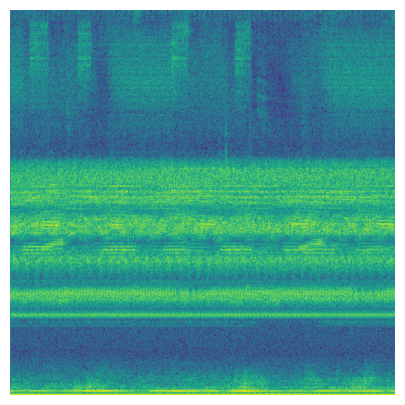

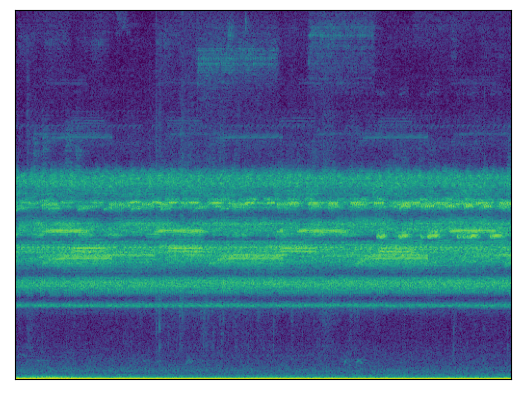

In [4]:
from Modules.Utils import plot_spectrogram
import librosa
def plot_reconstructions(imgs_original, imgs_reconstruction):
    output = torch.cat((imgs_original[0:4], imgs_reconstruction[0:4]), 0)
    img_grid = make_grid(output, nrow=4, pad_value=20)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.imshow(librosa.power_to_db(img_grid[1, :, :].cpu()), origin="lower")
    ax.axis("off")
    plt.show()
    return fig

def plot_spectrogram(spec, title=None, ylabel: str = 'freq_bin', aspect='auto', xmax=None, **kwargs):
    if ("numx_plots" in kwargs and "numy_plots" in kwargs):
        plt.figure(1, figsize=(12, 12))
        plt.subplot(kwargs["numx_plots"], kwargs["numy_plots"], kwargs["i"]+1)
        # print(axs.shape)
        # plt.set_title(title or 'Spectrogram (db)')
        # axs[kwargs["i"]].set_ylabel(ylabel)
        # axs[kwargs["i"]].set_xlabel('frame')
        # plt.set_axis_off()
        plt.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect, cmap="viridis")
        if xmax:
            plt.set_xlim((0, xmax))
        plt.xticks(())
        plt.yticks(())
    else:
        plt.figure()
        plt.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect, cmap="viridis")
        if xmax:
            plt.set_xlim((0, xmax))
        plt.xticks(())
        plt.yticks(())

iterator = iter(test_loader)
a = next(iterator)
print(a[0].shape)
plot_reconstructions(a[0][:, 0, 0], a[0][:, 0, 0])
plot_spectrogram(a[0][0, 0, 0])

In [5]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
torch.save(dataset_test, f"temporal/datasets/dataset_test_ae_jaguas_{time.day}_70%.pth")
torch.save(dataset_train, f"temporal/datasets/dataset_train_ae_jaguas_{time.day}_70%.pth")

1e-05


loss,█▁▂▁▁▄▃▂▃▂▂▁▂▃▂▁▂▄▂▇▂▃▂▂▁▂▁▁▂▅▁▂▂▁▂▂▁▂▁▅
step,▁▂▃▄▅▆▆▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▂▃▃▄▅▆▇▁
loss,221.90709
step,3


In [6]:
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas')
model.load_state_dict(torch.load(f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth', map_location=torch.device('cpu')))

FileNotFoundError: [Errno 2] No such file or directory: 'temporal/dataset_test_ae_jaguas'

In [ ]:
# root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


# dataset = SoundscapeData(root_path, audio_length=12, ext="WAV", win_length=1028)
# dataset_train, dataset_test = random_split(dataset,
#                                            [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
#                                            generator=torch.Generator().manual_seed(1024))
# Dataset_train = DataLoader(dataset_train, batch_size=54, shuffle=True)
# Dataset = DataLoader(dataset_test, batch_size=54, shuffle=True)

training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))


In [ ]:
originals, reconstructions, encodings, label, loss= testing.run()

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin[0:4],2)
testing.plot_psd(wav_origin[10:14],2)
#testing.plot_psd(wav_origin[18:22],2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons[0:4],2)
testing.plot_psd(wav_recons[10:14],2)
#testing.plot_psd(wav_recons[18:22],2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin,2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons,2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)


In [ ]:
plt.plot(wav_origin[12,0])
plt.plot(wav_recons[12,0], color='red', alpha = 0.4)

In [ ]:
# encodings_size = [64,9,9]
# plt.figure(figsize=(18, 18))
# model.to("cpu")
# for i, spec in enumerate(kmeans.cluster_centers_):
#     encodings = spec.reshape(encodings_size)
#     encodings = torch.tensor(encodings).float()
#     decodings = model.decoder(encodings).detach().numpy()
#     plt.subplot(9, 9, i + 1)
#     plt.imshow(decodings[0,:,:], cmap="inferno", interpolation="nearest",vmin=0, vmax=0.02)
#     plt.xticks(())
#     plt.yticks(())
